In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [ ]:
!pip install torch-summary

In [ ]:
import os
import time
import pickle
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.nn.utils as utls
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pad_sequence, pack_padded_sequence

from collections import Counter
from torchsummary import summary

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()[-1])

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13812936256
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4841762603844644549
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"



In [ ]:
SEED = 21

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
words = ['down','go','left','no','off','on','right','stop','up','yes']
num_classes = len(words)

In [ ]:
def apply_pre_emphasis(data):
    alpha = 0.95
    zero = np.zeros(1)
    orig_sig = np.append(data, zero)
    delay_sig = np.append(zero, data)
    output = (orig_sig - alpha*delay_sig)[:-1]
    return output

In [ ]:
def endpointing(sig, fs, win_dur, win_overlap):
    win_len = int(win_dur*fs*0.001)
    overlap = int(win_overlap*fs*0.001)
    rmse = librosa.feature.rms(sig, frame_length=win_len, 
                                hop_length=overlap, center=True)
    threshold = 0.01
    flag = 0
    
    frame_idx = 0
    while rmse[0][frame_idx] < threshold:
        frame_idx += 1
        if frame_idx == len(rmse[0]):
            flag = 1
            break
    start_idx = librosa.frames_to_samples(frame_idx, hop_length=overlap)
    
    rmse = librosa.feature.rms(sig[::-1], frame_length=win_len,
                                hop_length=overlap, center=True)
    frame_idx = 0
    while rmse[0][frame_idx] < threshold:
        frame_idx += 1
        if frame_idx == len(rmse[0]):
            flag = 1
            break
    end_idx = librosa.frames_to_samples(frame_idx, hop_length=overlap)
    end_idx = 0
    
    if flag or (start_idx>=(len(sig)-end_idx-1)):
        return sig, False
    else:
        return sig[start_idx:-end_idx-1], True

In [ ]:
def load_data(path):
    all_words = []
    for i in range(len(words)):
        data_path = path + "/" + words[i]
        word = []
        for file_name in os.listdir(data_path):
            x, fs = librosa.load(data_path + "/" + file_name)
            word.append(x)
        all_words.append(word)
    return all_words, fs

In [ ]:
def data_preprocessing(data, fs, win_dur, win_overlap):
    X = []
    for i in range(len(data)):
        x = []
        for j in range(len(data[i])):
            out, flag = endpointing(data[i][j], fs, win_dur, win_overlap)
            if flag:
                out = apply_pre_emphasis(out)
                x.append(out)
        X.append(x)
    return X

In [ ]:
def feature_extraction(data, fs, win_dur, win_overlap):
    all_features = []
    win_len = int(win_dur*fs*0.001)
    overlap = int(win_overlap*fs*0.001)
    for i in range(len(data)):
        features = []
        for j in range(len(data[i])):
            mfcc = librosa.feature.mfcc(data[i][j], sr=fs, n_mfcc=13, 
                                        n_fft=win_len, hop_length=overlap, 
                                        n_mels=64).T
            feature = []

            delta = []
            for k in range(len(mfcc)-1):
                temp = mfcc[k+1] - mfcc[k]
                delta.append(temp)
            
            deltaDelta = []
            for k in range(len(delta)-1):
                temp = delta[k+1] - delta[k]
                deltaDelta.append(temp)
                
            for k in range(len(deltaDelta)):
                temp = np.append(mfcc[k], delta[k])
                temp = np.append(temp, deltaDelta[k])
                feature.append(temp)
            features.append(np.array(feature))
        all_features.append(features)
    return all_features

In [ ]:
win_dur = 20
win_overlap = 10

In [ ]:
print("Loading Data...")
with open('EE679/train_clean.pkl', 'rb') as f:
    database = pickle.load(f)
data, fs = database['data'], database['fs']
del database
print("Processing Data...")
processed_clean_train_data = data_preprocessing(data, fs, win_dur, win_overlap)
print("Extracting Features...")
clean_train_features = feature_extraction(processed_clean_train_data, fs, win_dur, win_overlap)

Loading Data...
Processing Data...
Extracting Features...


/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=319
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=159
  n_fft, y.shape[-1]


In [ ]:
print("Loading Data...")
with open('EE679/test_clean.pkl', 'rb') as f:
    database = pickle.load(f)
data, fs = database['data'], database['fs']
del database
print("Processing Data...")
processed_clean_test_data = data_preprocessing(data, fs, win_dur, win_overlap)
print("Extracting Features...")
clean_test_features = feature_extraction(processed_clean_test_data, fs, win_dur, win_overlap)

Loading Data...
Processing Data...
Extracting Features...


In [ ]:
print("Loading Data...")
with open('EE679/train_noisy.pkl', 'rb') as f:
    database = pickle.load(f)
data, fs = database['data'], database['fs']
del database
print("Processing Data...")
processed_noisy_train_data = data_preprocessing(data, fs, win_dur, win_overlap)
print("Extracting Features...")
noisy_train_features = feature_extraction(processed_noisy_train_data, fs, win_dur, win_overlap)

Loading Data...
Processing Data...
Extracting Features...


In [ ]:
print("Loading Data...")
with open('EE679/test_noisy.pkl', 'rb') as f:
    database = pickle.load(f)
data, fs = database['data'], database['fs']
del database
print("Processing Data...")
processed_noisy_test_data = data_preprocessing(data, fs, win_dur, win_overlap)
print("Extracting Features...")
noisy_test_features = feature_extraction(processed_noisy_test_data, fs, win_dur, win_overlap)

Loading Data...
Processing Data...
Extracting Features...


In [ ]:
def filter_features(features):
    temp = features
    del_idx = []
    for k in range(len(temp)):
        if len(temp[k].shape)==1:
            del_idx.append(k)
    return del_idx

del_idx = filter_features(clean_train_features[8])
templist = [i for j, i in enumerate(clean_train_features[8]) if j not in del_idx]
clean_train_features[8] = templist

del_idx = filter_features(clean_train_features[9])
templist = [i for j, i in enumerate(clean_train_features[9]) if j not in del_idx]
clean_train_features[9] = templist

In [ ]:
del_idx = filter_features(noisy_train_features[8])
templist = [i for j, i in enumerate(noisy_train_features[8]) if j not in del_idx]
noisy_train_features[8] = templist

del_idx = filter_features(noisy_train_features[9])
templist = [i for j, i in enumerate(noisy_train_features[9]) if j not in del_idx]
noisy_train_features[9] = templist

In [ ]:
def create_dataset(features):
    X = []
    y = []
    for j in range(len(features)):
        for i in range(len(features[j])):
            temp = torch.FloatTensor(features[j][i])
            X.append(temp)
            y.append(j)
    X, y = shuffle(X, y)
    return X, y

clean_X_train, clean_y_train = create_dataset(clean_train_features)
clean_X_test, clean_y_test = create_dataset(clean_test_features)

# noisy_X_train, noisy_y_train = create_dataset(noisy_train_features)
# noisy_X_test, noisy_y_test = create_dataset(noisy_test_features)

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.X[idx], self.y[idx]

cleantrainset = AudioDataset(clean_X_train, clean_y_train)
cleantestset = AudioDataset(clean_X_test, clean_y_test)

# noisytrainset = AudioDataset(noisy_X_train, noisy_y_train)
# noisytestset = AudioDataset(noisy_X_test, noisy_y_test)

In [ ]:
def collate_fn_pad(batch):
    '''
    Pads batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## labels
    labels = torch.tensor([ label for _, label in batch ]).long().to(device)
    ## get sequence lengths
    lengths = torch.tensor([ t.shape[0] for t, _ in batch ])
    ## pad
    batch = [ torch.Tensor(t).to(device) for t, _ in batch ]
    batch = pad_sequence(batch, batch_first=True)
    ## compute mask
    mask = (batch != 0).to(device)
    return batch, lengths, mask, labels

cleantestloader = DataLoader(cleantestset, batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_fn_pad)
noisytestloader = DataLoader(noisytestset, batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_fn_pad)

(array([2308., 2310., 2295., 2301., 2302., 2298., 2294., 2327., 2313.,
        2320.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

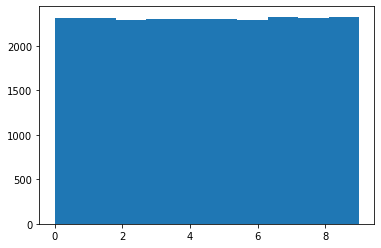

In [ ]:
plt.hist(clean_y_train)

(array([247., 238., 261., 245., 257., 240., 251., 245., 268., 249.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

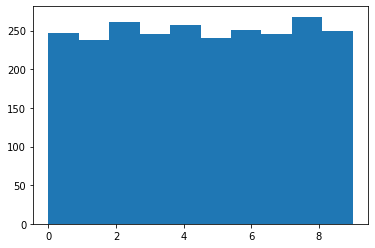

In [ ]:
plt.hist(clean_y_test)

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional=False, dropout_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout_prob, bidirectional=bidirectional)
        if bidirectional==True:
            self.fc = nn.Linear(2*hidden_dim, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        nn.init.normal_(self.fc.weight,0.0,1.0)
        
    def forward(self, inp, l):
        x = pack_padded_sequence(inp, l.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, (h, c) = self.lstm(x)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        # Extract the outputs for the last timestep of each example
        idx = (torch.LongTensor(l) - 1).view(-1, 1).expand(len(l), lstm_out.size(2))
        time_dimension = 1
        idx = idx.unsqueeze(time_dimension)
        if lstm_out.is_cuda:
            idx = idx.cuda(lstm_out.data.get_device())
        # Shape: (batch_size, rnn_hidden_dim)
        out = lstm_out.gather(time_dimension, Variable(idx)).squeeze(time_dimension)

        out = self.relu(out)
        out = self.fc(out)
        return out, lstm_out

class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional=False, dropout_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout_prob, bidirectional=bidirectional)
        if bidirectional==True:
            self.fc = nn.Linear(2*hidden_dim, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        nn.init.normal_(self.fc.weight,0.0,1.0)
        
    def forward(self, inp, l):
        x = pack_padded_sequence(inp, l, batch_first=True, enforce_sorted=False)
        gru_out, h = self.gru(x)
        gru_out, _ = pad_packed_sequence(gru_out, batch_first=True)

        # Extract the outputs for the last timestep of each example
        idx = (torch.LongTensor(l) - 1).view(-1, 1).expand(len(l), gru_out.size(2))
        time_dimension = 1
        idx = idx.unsqueeze(time_dimension)
        if gru_out.is_cuda:
            idx = idx.cuda(gru_out.data.get_device())
        # Shape: (batch_size, rnn_hidden_dim)
        out = gru_out.gather(time_dimension, Variable(idx)).squeeze(time_dimension)

        out = self.relu(out)
        out = self.fc(out)
        return out, gru_out

In [ ]:
# test_model = LSTMNet(39, 64, 10, 2).to(device)
# for sample, lengths, mask, label in testloader:
#     out, _ = test_model(sample, lengths)
#     break
# # summary(test_model, (sample, lengths))
# print(f"Output shape: {out.shape}")
# print(f"Input shape: {sample.shape}")

Output shape: torch.Size([64, 10])
Input shape: torch.Size([64, 98, 39])


In [ ]:
#@title Evaluate Function

def evaluate(loader, rnn_model):
  rnn_model.eval()
  predictions = []
  labels = []
  loss_list = []

  start_time = time.clock()
  with torch.no_grad():
    for batch, lengths, mask, label in loader:
      out, rnn_out= rnn_model(batch, lengths)
      loss = F.cross_entropy(out, label)
      loss_list.append(loss.item())
  return np.mean(loss_list)

In [ ]:
#@title Plot Grad Flow
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.show()

In [ ]:
def train(training_data, n_layers = 2, bidirectional=False, learn_rate=0.01, hidden_dim=64, batch_size=32, dropout_prob=0.2, epochs=25):
    # Setting common hyperparameters
    input_dim = clean_X_train[0].shape[1]
    output_dim = num_classes
    train_loss = []
    test_loss = []
    test_los = 0
    print("######## Hyper Parameters #########")
    print("Hidden Dimension: {}".format(hidden_dim))
    print("Num LSTM layers: {}".format(n_layers))
    print("Learning Rate: {}".format(learn_rate))
    print("Dropout Prob: {}".format(dropout_prob))
    print("Batch Size: {}".format(batch_size))
    print("Num Epochs: {}".format(epochs))
    print("###################################")

    trainloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn_pad)
    dataset_len = len(training_data)

    model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_prob).to(device)
    model.train()
    
    # Defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    print("\nTraining the ASR model")
    epoch_times = []
    # Start training loop
    for epoch in range(1,epochs+1):
        start_time = time.clock()
        avg_loss = 0.
        counter = 0  

        model.train()
        model.zero_grad()
        for batch, lengths, mask, label in trainloader:
            counter += batch_size
            out, rnn_out = model(batch, lengths)
            
            model.zero_grad()
            loss = criterion(out, label)
            avg_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_loss.append(avg_loss/counter)

            if counter%(dataset_len//5) == 0:
                print("Epoch {} | Step: {}/{} | Average Loss for Epoch: {:.3f} | Time Elapsed: {:.2f}".format(epoch, counter, dataset_len, avg_loss/counter, time.clock()-start_time))

        plot_grad_flow(model.named_parameters())
        train_loss.append(avg_loss/counter)
        test_los = evaluate(cleantestloader, model)
        test_loss.append(test_los)
        print("Epoch {}/{} Done | Train Loss: {:.3f} | Test Loss: {:.3f} | Time Elapsed: {:.2f}\n".format(epoch, epochs, avg_loss/counter, test_los, time.clock()-start_time))
        epoch_times.append(time.clock()-start_time)
    print("Total Training Time: {} seconds".format(sum(epoch_times)))
    return model, train_loss, test_loss

######## Hyper Parameters #########
Hidden Dimension: 32
Num LSTM layers: 2
Learning Rate: 0.003
Dropout Prob: 0.1
Batch Size: 128
Num Epochs: 30
###################################

Training the ASR model


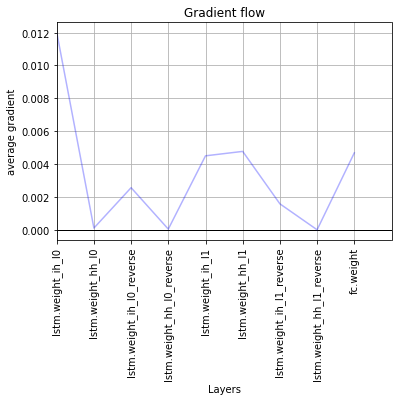

Epoch 1/30 Done | Train Loss: 0.014 | Test Loss: 1.373 | Time Elapsed: 8.77



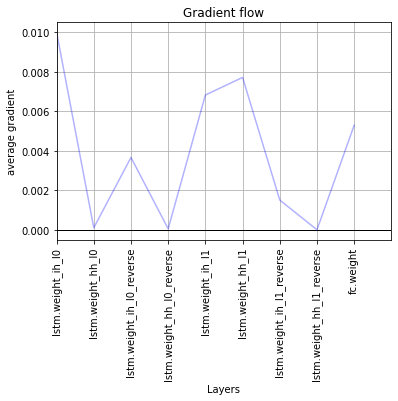

Epoch 2/30 Done | Train Loss: 0.010 | Test Loss: 1.072 | Time Elapsed: 8.70



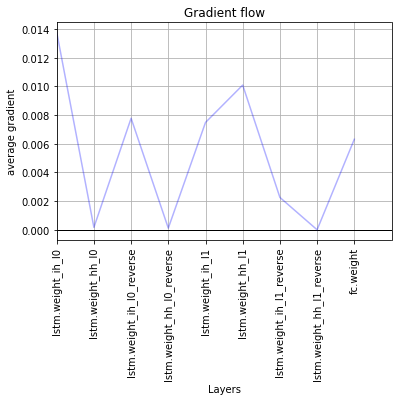

Epoch 3/30 Done | Train Loss: 0.008 | Test Loss: 0.928 | Time Elapsed: 8.67



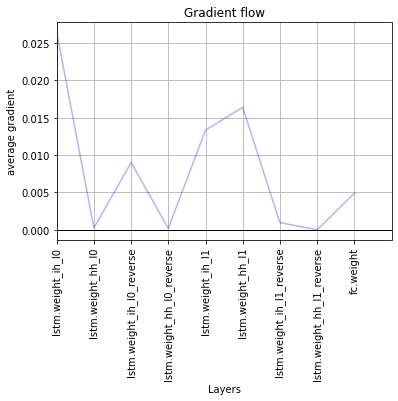

Epoch 4/30 Done | Train Loss: 0.006 | Test Loss: 0.702 | Time Elapsed: 8.76



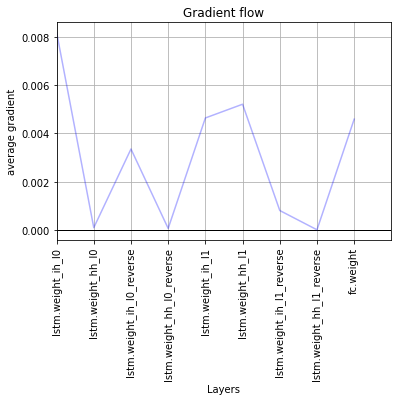

Epoch 5/30 Done | Train Loss: 0.005 | Test Loss: 0.587 | Time Elapsed: 8.83



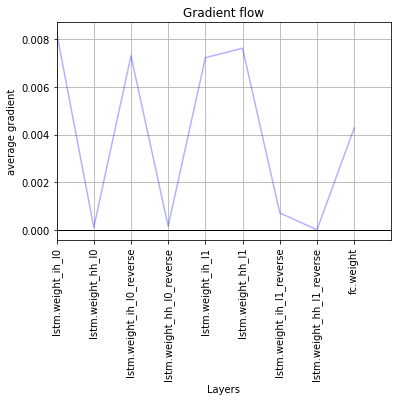

Epoch 6/30 Done | Train Loss: 0.004 | Test Loss: 0.475 | Time Elapsed: 8.80



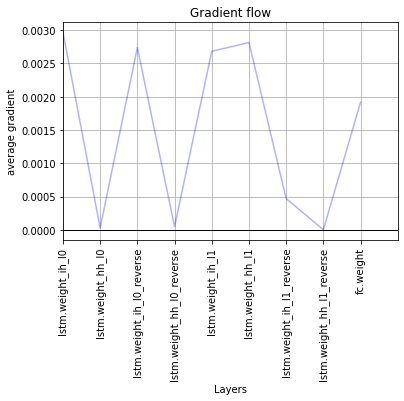

Epoch 7/30 Done | Train Loss: 0.003 | Test Loss: 0.389 | Time Elapsed: 9.18



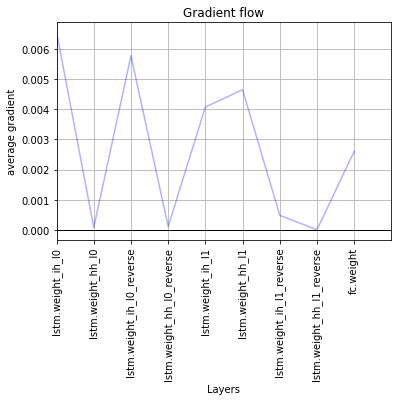

Epoch 8/30 Done | Train Loss: 0.003 | Test Loss: 0.342 | Time Elapsed: 8.75



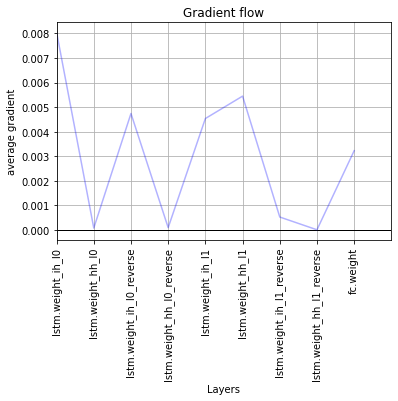

Epoch 9/30 Done | Train Loss: 0.003 | Test Loss: 0.274 | Time Elapsed: 8.80



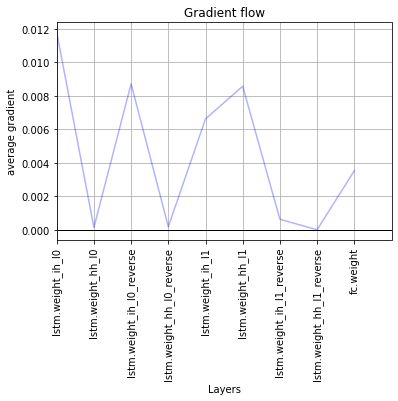

Epoch 10/30 Done | Train Loss: 0.002 | Test Loss: 0.281 | Time Elapsed: 8.78



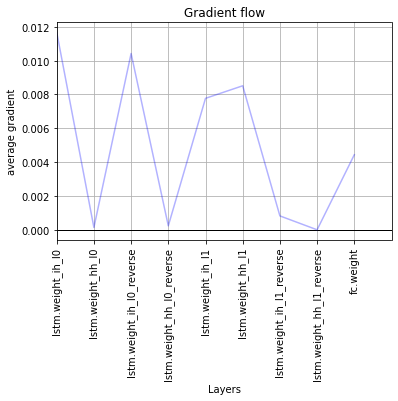

Epoch 11/30 Done | Train Loss: 0.002 | Test Loss: 0.211 | Time Elapsed: 8.77



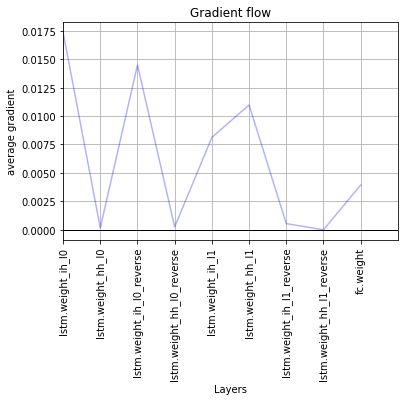

Epoch 12/30 Done | Train Loss: 0.002 | Test Loss: 0.244 | Time Elapsed: 8.68



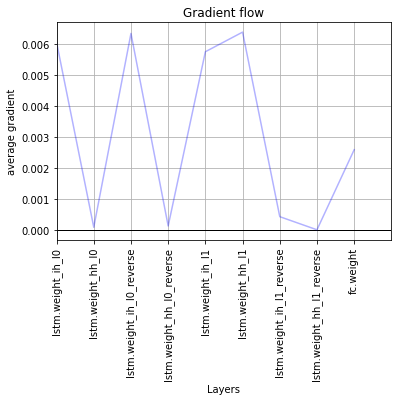

Epoch 13/30 Done | Train Loss: 0.002 | Test Loss: 0.193 | Time Elapsed: 8.70



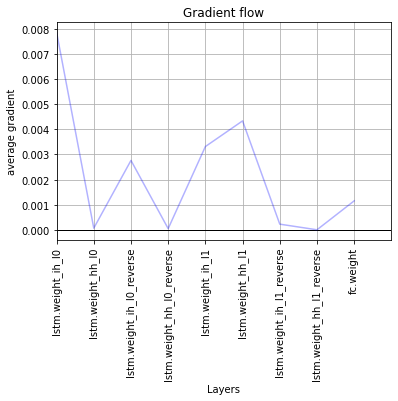

Epoch 14/30 Done | Train Loss: 0.002 | Test Loss: 0.187 | Time Elapsed: 8.92



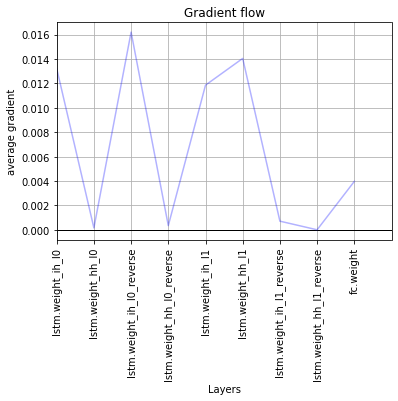

Epoch 15/30 Done | Train Loss: 0.002 | Test Loss: 0.182 | Time Elapsed: 8.86



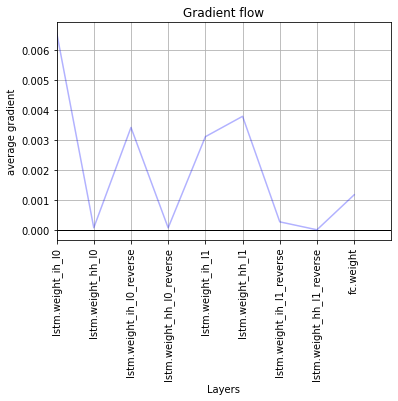

Epoch 16/30 Done | Train Loss: 0.002 | Test Loss: 0.155 | Time Elapsed: 8.75



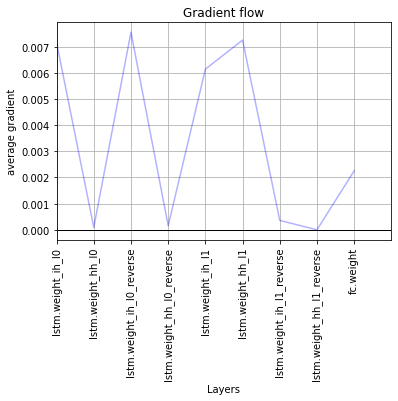

Epoch 17/30 Done | Train Loss: 0.001 | Test Loss: 0.184 | Time Elapsed: 8.79



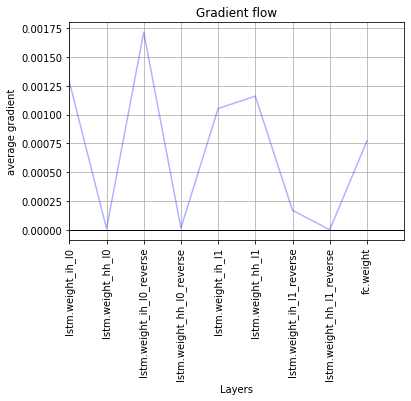

Epoch 18/30 Done | Train Loss: 0.001 | Test Loss: 0.131 | Time Elapsed: 8.82



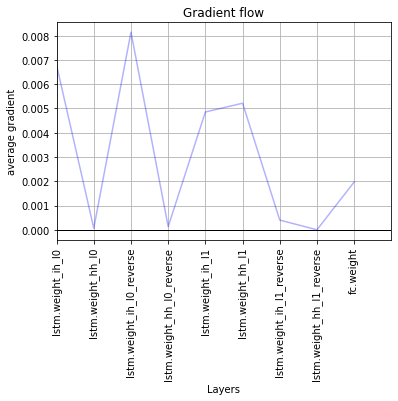

Epoch 19/30 Done | Train Loss: 0.001 | Test Loss: 0.138 | Time Elapsed: 8.81



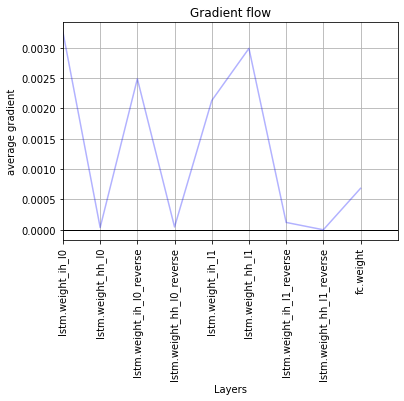

Epoch 20/30 Done | Train Loss: 0.001 | Test Loss: 0.151 | Time Elapsed: 8.75



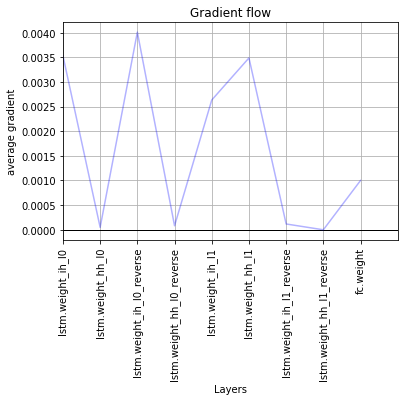

Epoch 21/30 Done | Train Loss: 0.001 | Test Loss: 0.156 | Time Elapsed: 8.78



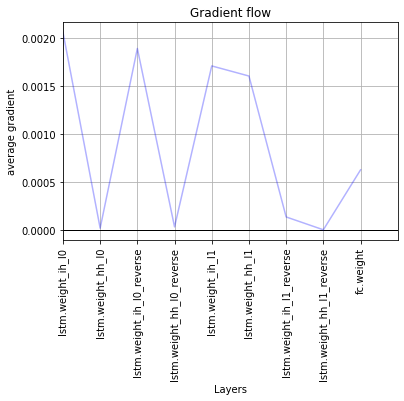

Epoch 22/30 Done | Train Loss: 0.001 | Test Loss: 0.150 | Time Elapsed: 8.80



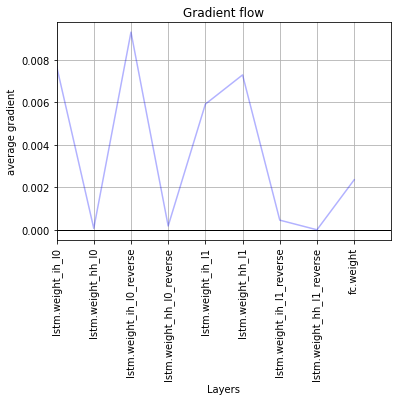

Epoch 23/30 Done | Train Loss: 0.001 | Test Loss: 0.131 | Time Elapsed: 8.75



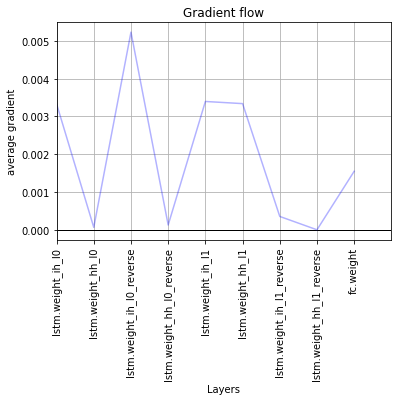

Epoch 24/30 Done | Train Loss: 0.001 | Test Loss: 0.100 | Time Elapsed: 8.82



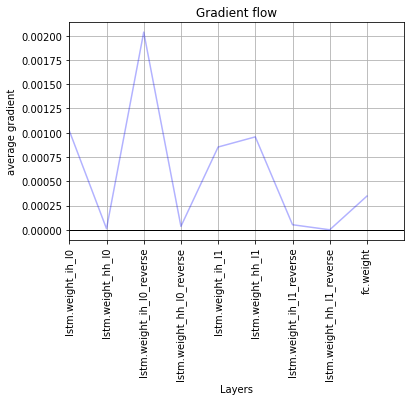

Epoch 25/30 Done | Train Loss: 0.001 | Test Loss: 0.097 | Time Elapsed: 8.78



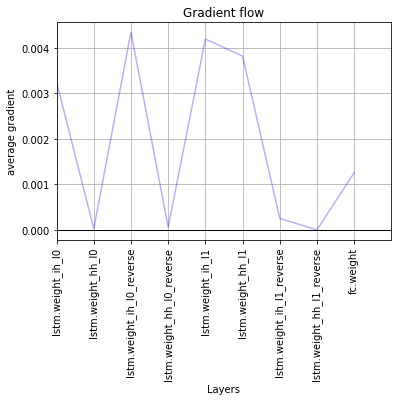

Epoch 26/30 Done | Train Loss: 0.001 | Test Loss: 0.106 | Time Elapsed: 8.78



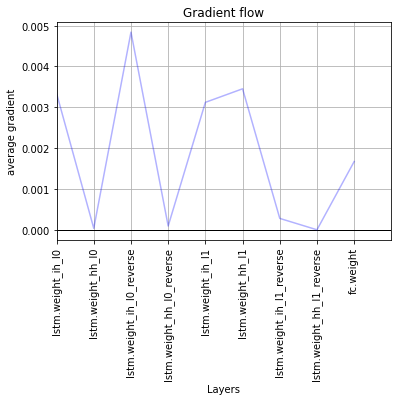

Epoch 27/30 Done | Train Loss: 0.001 | Test Loss: 0.127 | Time Elapsed: 8.72



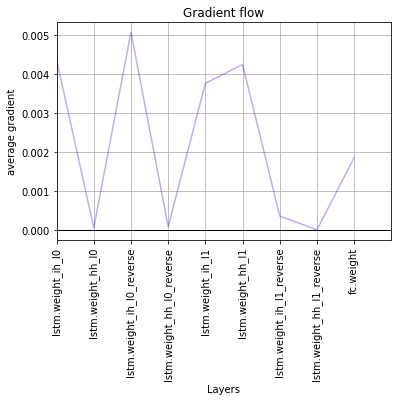

Epoch 28/30 Done | Train Loss: 0.001 | Test Loss: 0.100 | Time Elapsed: 8.72



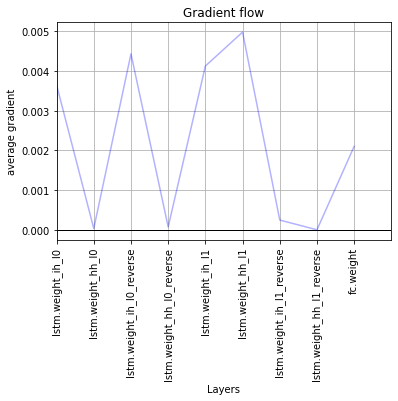

Epoch 29/30 Done | Train Loss: 0.001 | Test Loss: 0.091 | Time Elapsed: 8.72



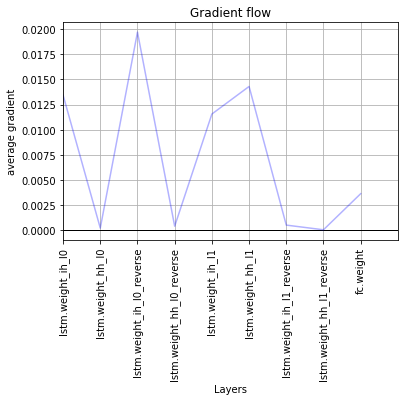

Epoch 30/30 Done | Train Loss: 0.001 | Test Loss: 0.081 | Time Elapsed: 8.71

Total Training Time: 263.46893700000015 seconds


In [ ]:
n_layers = 2
bidirectional = True
lr = 0.003
hid_dim = 32
num_epoch = 30
batch_size = 128
drop_prob = 0.1

rnn_model, train_loss, test_loss = train(cleantrainset, n_layers, bidirectional, lr, hid_dim, batch_size, drop_prob, num_epoch)  

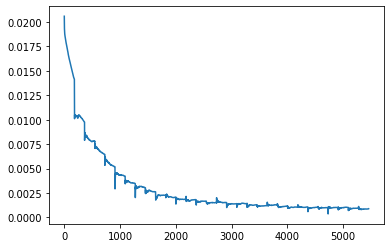

In [ ]:
plt.plot(train_loss)

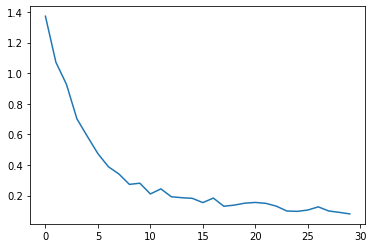

In [ ]:
plt.plot(test_loss)

In [ ]:
def test(loader, rnn_model):
  rnn_model.eval()
  predictions = []
  labels = []

  start_time = time.clock()
  with torch.no_grad():
    for batch, lengths, mask, label in loader:
      out, rnn_out= rnn_model(batch, lengths)
      labels += label.cpu().tolist()
      out = out.cpu().numpy()
      preds = np.argmax(out, axis=1).tolist()
      predictions += preds

  accu = accuracy_score(labels, predictions)
  print("Accuracy = {}".format(accu))
  print("Confusion Matrix")
  print(confusion_matrix(labels, predictions))

In [ ]:
train_loader = DataLoader(cleantrainset, 128, shuffle=False, num_workers=0, collate_fn=collate_fn_pad)
test(train_loader, rnn_model)

Accuracy = 0.9726894399167678
Confusion Matrix
[[2233   24    1   20    0    6    0   17    6    1]
 [  29 2188    1   60    2    3    4   11   11    1]
 [   0    0 2248    9    8    0    0    6   14   10]
 [  19   55    5 2208    2    3    0    5    4    0]
 [   1    4    1    0 2262    3    0    4   26    1]
 [   6    4    1    0   21 2256    2    2    6    0]
 [   1    8   30    4    7    5 2236    2    1    0]
 [   6    7    3    2    3    1    0 2269   36    0]
 [   0    2    7    1   23    5    0   10 2265    0]
 [   9    3   19   11    2    0    1    0    2 2273]]


In [ ]:
test(cleantestloader, rnn_model)

Accuracy = 0.9752099160335865
Confusion Matrix
[[237   2   1   3   0   1   0   3   0   0]
 [  2 228   1   7   0   0   0   0   0   0]
 [  0   0 254   3   1   0   0   1   1   1]
 [  4   1   0 236   0   2   0   0   2   0]
 [  0   0   0   0 254   0   0   1   2   0]
 [  1   1   1   0   1 236   0   0   0   0]
 [  0   1   1   0   2   1 245   1   0   0]
 [  1   0   1   0   1   0   0 241   1   0]
 [  0   1   1   0   2   0   0   2 262   0]
 [  0   1   1   1   0   0   0   0   0 246]]


In [ ]:
test(noisytestloader, rnn_model)

Accuracy = 0.8544
Confusion Matrix
[[204  12   2   5   0   2   1  12   1   8]
 [  0 200   0  15   4   0   1   6   3   9]
 [  1   0 209   1   2   0   2   5   3  38]
 [  9  24   3 178   3   0   2   6   7  13]
 [  1   1   3   0 236   1   0   3  12   0]
 [  1   1   0   0  36 188   5   0   5   3]
 [  0   1   6   2   1   2 229   0   2   8]
 [  3   2   0   2   8   0   0 221   3   6]
 [  2   3   7   1  15   1   1   9 229   0]
 [  2   1   1   0   1   0   0   1   1 242]]


In [ ]:
# PATH = './asr_10_words.pth'
# torch.save(rnn_model.state_dict(), PATH)

with open('vocab_list.pkl', 'wb') as f:
    pickle.dump(words, f)

######## Hyper Parameters #########
Hidden Dimension: 32
Num LSTM layers: 2
Learning Rate: 0.003
Dropout Prob: 0.1
Batch Size: 128
Num Epochs: 30
###################################

Training the ASR model


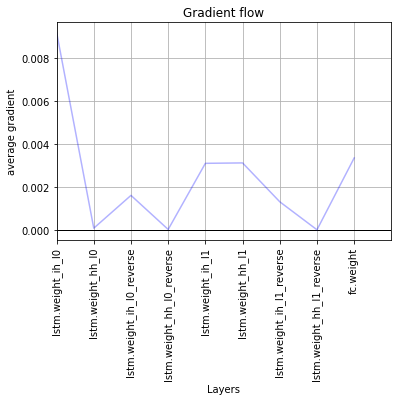

Epoch 1/30 Done | Train Loss: 0.016 | Test Loss: 1.820 | Time Elapsed: 7.53



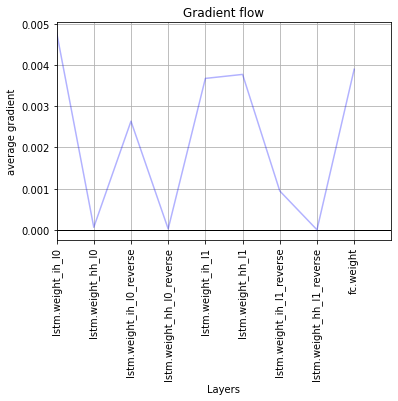

Epoch 2/30 Done | Train Loss: 0.014 | Test Loss: 1.641 | Time Elapsed: 7.65



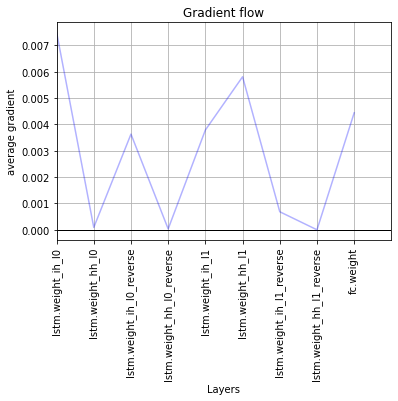

Epoch 3/30 Done | Train Loss: 0.013 | Test Loss: 1.408 | Time Elapsed: 7.87



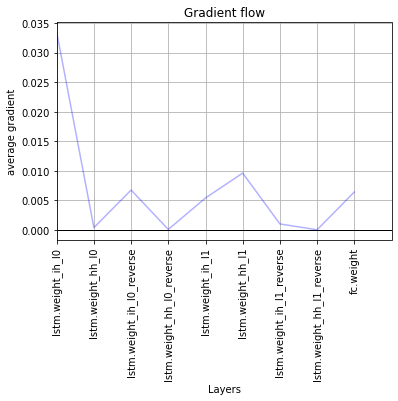

Epoch 4/30 Done | Train Loss: 0.010 | Test Loss: 1.036 | Time Elapsed: 7.70



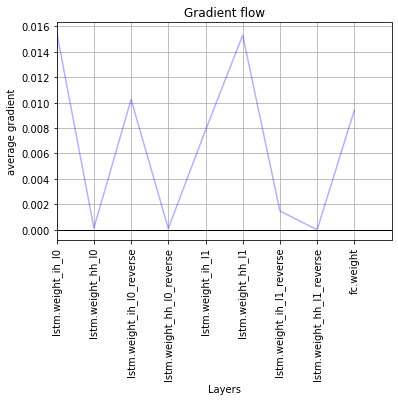

Epoch 5/30 Done | Train Loss: 0.008 | Test Loss: 0.874 | Time Elapsed: 8.04



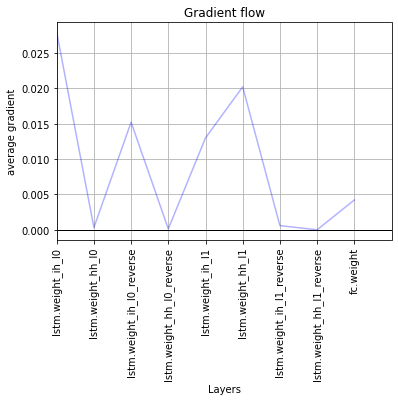

Epoch 6/30 Done | Train Loss: 0.007 | Test Loss: 0.732 | Time Elapsed: 7.93



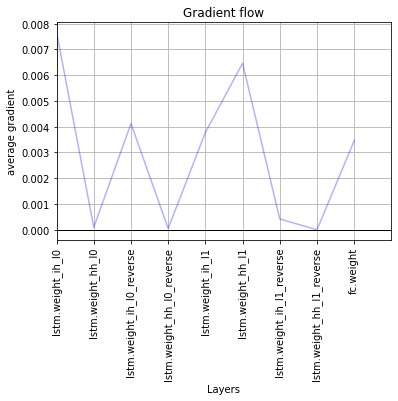

Epoch 7/30 Done | Train Loss: 0.006 | Test Loss: 0.623 | Time Elapsed: 7.71



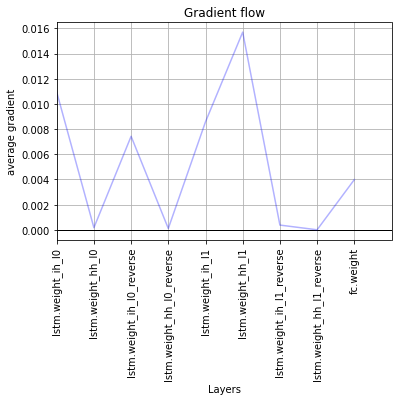

Epoch 8/30 Done | Train Loss: 0.005 | Test Loss: 0.610 | Time Elapsed: 7.93



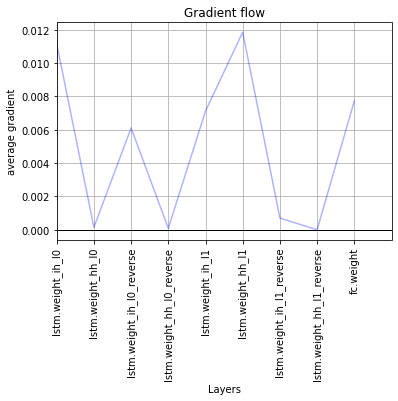

Epoch 9/30 Done | Train Loss: 0.005 | Test Loss: 0.548 | Time Elapsed: 7.51



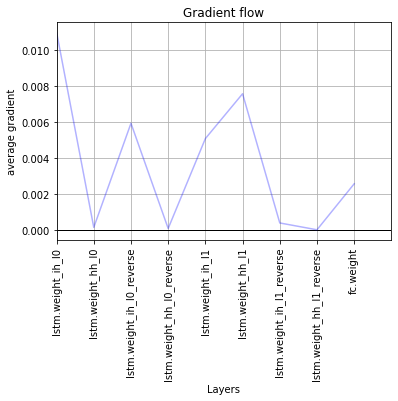

Epoch 10/30 Done | Train Loss: 0.004 | Test Loss: 0.477 | Time Elapsed: 7.65



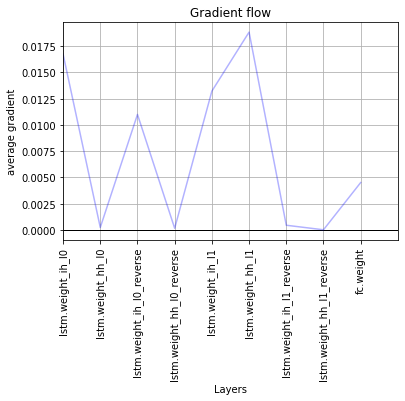

Epoch 11/30 Done | Train Loss: 0.004 | Test Loss: 0.422 | Time Elapsed: 7.45



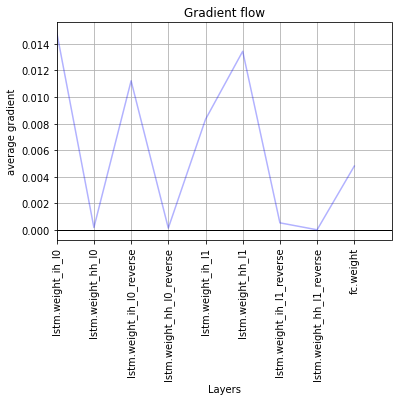

Epoch 12/30 Done | Train Loss: 0.003 | Test Loss: 0.396 | Time Elapsed: 7.60



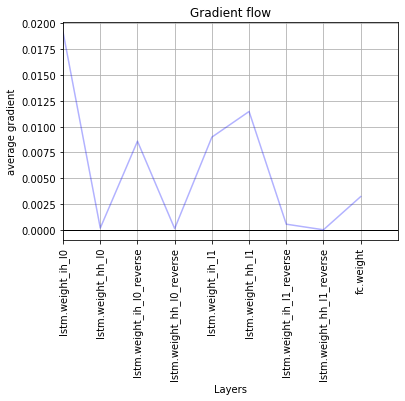

Epoch 13/30 Done | Train Loss: 0.003 | Test Loss: 0.367 | Time Elapsed: 7.54



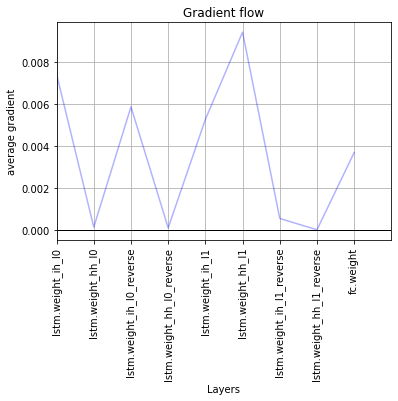

Epoch 14/30 Done | Train Loss: 0.003 | Test Loss: 0.315 | Time Elapsed: 7.76



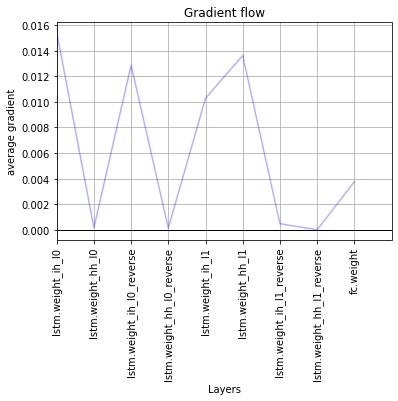

Epoch 15/30 Done | Train Loss: 0.003 | Test Loss: 0.337 | Time Elapsed: 7.60



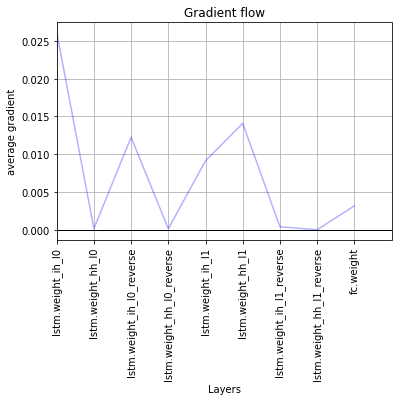

Epoch 16/30 Done | Train Loss: 0.003 | Test Loss: 0.300 | Time Elapsed: 7.76



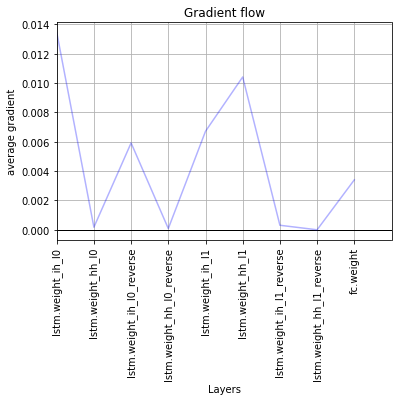

Epoch 17/30 Done | Train Loss: 0.003 | Test Loss: 0.278 | Time Elapsed: 7.84



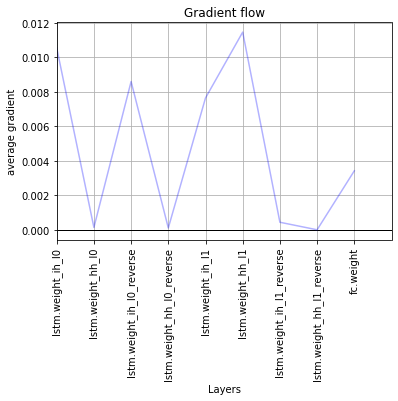

Epoch 18/30 Done | Train Loss: 0.002 | Test Loss: 0.251 | Time Elapsed: 7.76



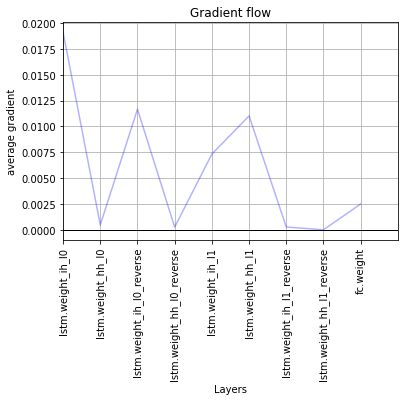

Epoch 19/30 Done | Train Loss: 0.002 | Test Loss: 0.271 | Time Elapsed: 7.50



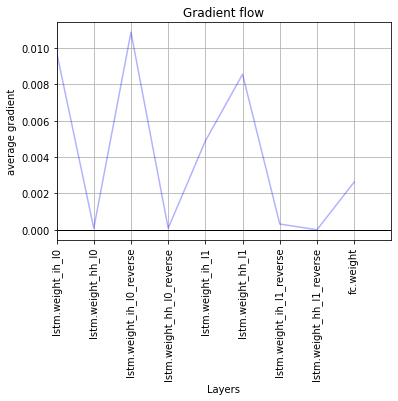

Epoch 20/30 Done | Train Loss: 0.002 | Test Loss: 0.240 | Time Elapsed: 7.53



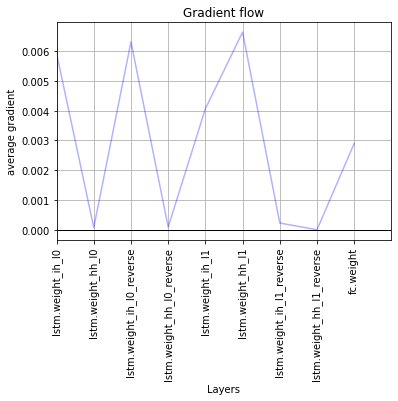

Epoch 21/30 Done | Train Loss: 0.002 | Test Loss: 0.222 | Time Elapsed: 7.78



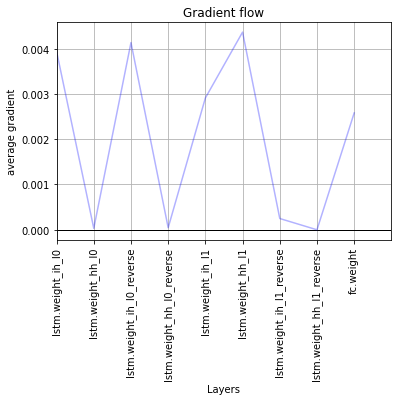

Epoch 22/30 Done | Train Loss: 0.002 | Test Loss: 0.205 | Time Elapsed: 7.63



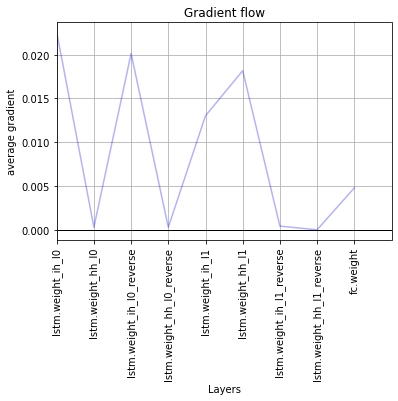

Epoch 23/30 Done | Train Loss: 0.002 | Test Loss: 0.191 | Time Elapsed: 7.71



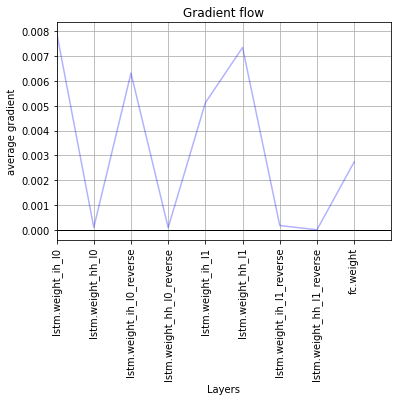

Epoch 24/30 Done | Train Loss: 0.002 | Test Loss: 0.184 | Time Elapsed: 7.66



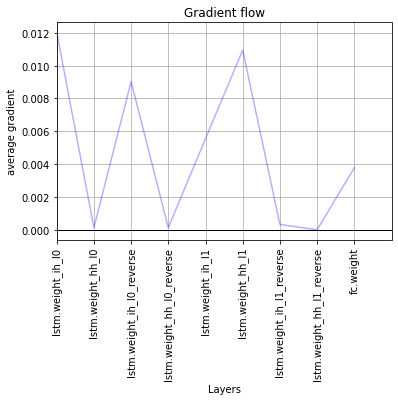

Epoch 25/30 Done | Train Loss: 0.002 | Test Loss: 0.177 | Time Elapsed: 7.66



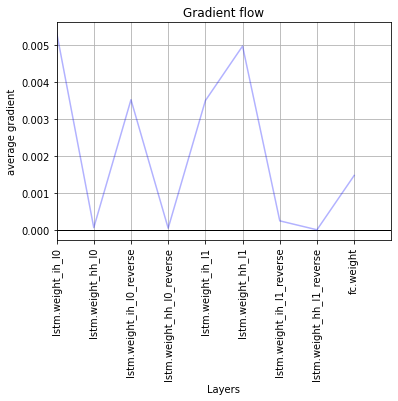

Epoch 26/30 Done | Train Loss: 0.002 | Test Loss: 0.182 | Time Elapsed: 7.56



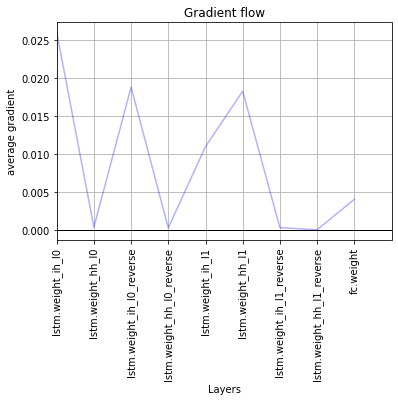

Epoch 27/30 Done | Train Loss: 0.002 | Test Loss: 0.164 | Time Elapsed: 7.51



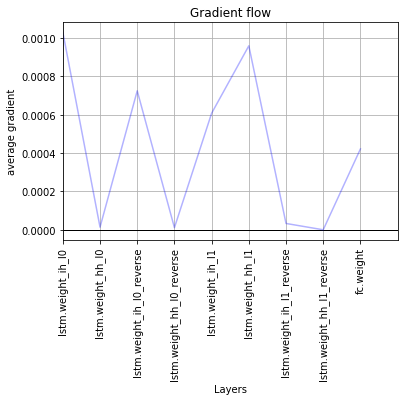

Epoch 28/30 Done | Train Loss: 0.002 | Test Loss: 0.192 | Time Elapsed: 7.52



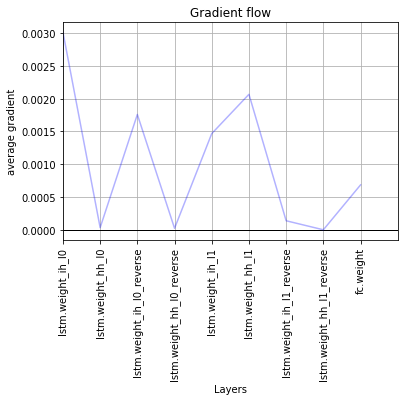

Epoch 29/30 Done | Train Loss: 0.002 | Test Loss: 0.149 | Time Elapsed: 7.50



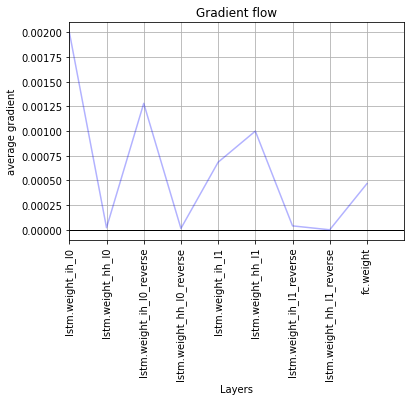

Epoch 30/30 Done | Train Loss: 0.002 | Test Loss: 0.172 | Time Elapsed: 7.52

Total Training Time: 229.92447299999992 seconds


In [ ]:
n_layers = 2
bidirectional = True
lr = 0.003
hid_dim = 32
num_epoch = 30
batch_size = 128
drop_prob = 0.1

noisy_rnn_model, noisy_train_loss, noisy_test_loss = train(noisytrainset, n_layers, bidirectional, lr, hid_dim, batch_size, drop_prob, num_epoch) 

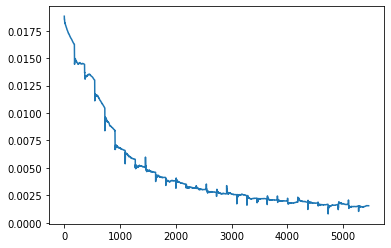

In [ ]:
plt.plot(noisy_train_loss)

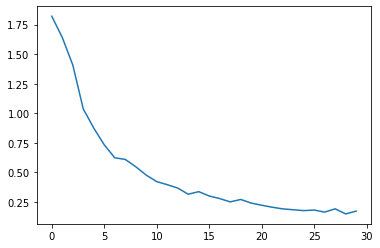

In [ ]:
plt.plot(noisy_test_loss)

In [ ]:
test(cleantestloader, noisy_rnn_model)

Accuracy = 0.9464214314274291
Confusion Matrix
[[224   7   0  10   0   3   0   1   2   0]
 [  2 225   0   7   2   1   0   1   0   0]
 [  0   1 249   2   2   0   2   0   0   5]
 [  7  16   0 215   2   1   2   1   1   0]
 [  0   1   0   0 248   4   0   1   3   0]
 [  0   0   0   0   2 237   1   0   0   0]
 [  1   1   0   0   0   0 249   0   0   0]
 [  3   4   0   0   3   0   0 232   3   0]
 [  0   2   0   0  16   3   0   1 246   0]
 [  0   1   3   1   0   0   1   0   1 242]]


In [ ]:
test(noisytestloader, noisy_rnn_model)

Accuracy = 0.9264
Confusion Matrix
[[214  13   0  13   0   3   1   2   1   0]
 [  4 217   1   9   3   2   0   1   0   1]
 [  1   1 247   2   2   0   2   0   1   5]
 [  6  14   3 213   1   1   3   1   3   0]
 [  0   0   2   1 243   4   0   1   6   0]
 [  0   1   0   0   2 234   1   0   1   0]
 [  0   1   1   1   1   4 243   0   0   0]
 [  3   9   0   0   6   0   0 220   7   0]
 [  0   1   0   2  10   3   0   2 250   0]
 [  1   0  10   2   0   0   0   0   1 235]]
